# Regression Line Slope


In [1]:
import sys, os, os.path
import pandas as pd
import numpy as np
import talib
from talib.abstract import *

import matplotlib.pyplot as plt
%matplotlib inline


if not 'EXPERIMENT_HOME' in os.environ: # Configure local paths if not already defined
    ML_HOME = os.path.abspath(os.path.join("..", "..","ml_home")) # ML workspace
    EXPERIMENT_HOME = os.path.abspath(os.path.join(ML_HOME, "..")) # Experiment workspace
    DATA_HOME = os.path.abspath(os.path.join(EXPERIMENT_HOME,"dataset","historical")) # Dataset location
    os.environ["EXPERIMENT_HOME"] = EXPERIMENT_HOME
    os.environ["DATA_HOME"] = DATA_HOME
    sys.path.insert(0, EXPERIMENT_HOME)
    sys.path.insert(0, ML_HOME) # Add to path so can load our library
    os.chdir(EXPERIMENT_HOME) # Change working directory to experiment workspace
print("Experiment Home: ", os.path.abspath(os.curdir), "; Data Home:", DATA_HOME)

Experiment Home:  /home/jovyan ; Data Home: /home/jovyan/dataset/historical


,High,Low,Open,Close,Volume,Adj Close,Date,Ticker,Sector,Industry,DailyReturn,DailyPriceVariation,PriceStDev-5d
0,181.5,179.0,181.0,179.0,5752000.0,138.838455,2015-01-05,SCB,Financials,Banking,0.016621,0.013966,2.049390
1,176.5,173.5,176.0,175.0,10430400.0,135.735931,2015-01-06,SCB,Financials,Banking,0.022600,0.017143,3.768289
2,179.0,175.0,175.5,178.0,4456700.0,138.062836,2015-01-07,SCB,Financials,Banking,-0.016998,0.022472,3.209361
3,182.0,180.0,181.0,182.0,3963800.0,141.165359,2015-01-08,SCB,Financials,Banking,-0.022223,0.010989,2.949576
4,184.5,182.0,183.0,184.5,4298800.0,143.104462,2015-01-09,SCB,Financials,Banking,-0.013643,0.013550,3.667424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,150.5,148.0,150.0,148.0,7222400.0,141.339996,2019-12-24,KBANK,Financials,Banking,0.010084,0.016892,0.670820
2434,151.0,147.0,147.5,151.0,4195900.0,144.205002,2019-12-25,KBANK,Financials,Banking,-0.020068,0.026490,1.151086
2435,151.5,149.5,151.0,150.0,4141800.0,143.250000,2019-12-26,KBANK,Financials,Banking,0.006645,0.013333,1.083974
2436,151.5,149.0,151.0,150.0,5252500.0,143.250000,2019-12-27,KBANK,Financials,Banking,0.000000,0.016667,1.095445


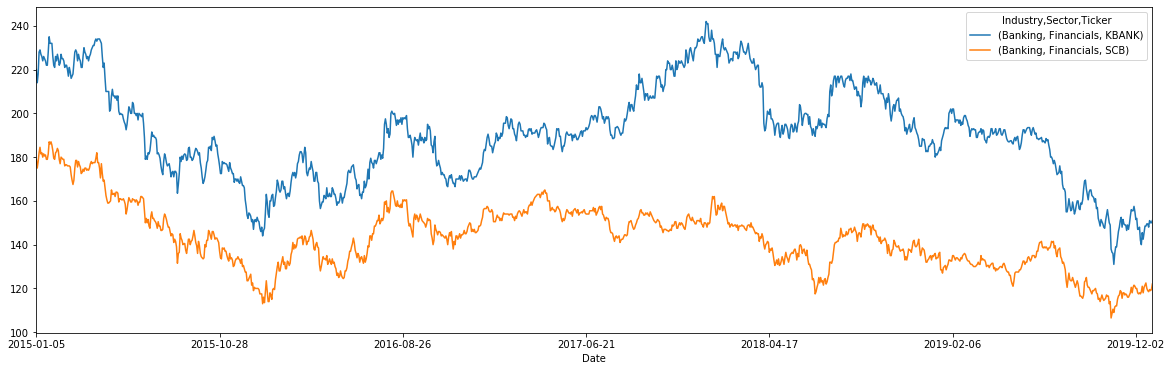

In [85]:
from dataset import pilot10stock, sectors, industries
from dataset import years
from dataset import Yr2015, Yr2019
from data.src import stockdata_fetch_local

df = stockdata_fetch_local(Yr2015.dt_start, Yr2019.dt_end, ["SCB","KBANK"])
tbl = df.pivot_table(values='Close', index='Date', columns=['Industry', 'Sector', 'Ticker'])
tbl.plot()
df

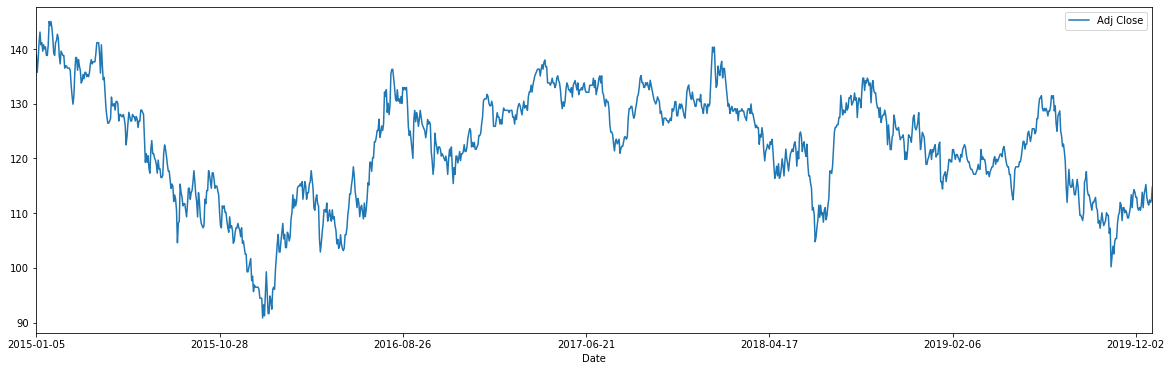

In [96]:
series1 = df[df['Ticker']=='SCB']
series2 = df[df['Ticker']=='KBANK']

# Set date column as index of the time-series
series1 = series1.set_index(series1.Date)
series2 = series2.set_index(series2.Date)

series1[['Adj Close']].plot()

# Fitting Regression Line to Noisy Data

In [97]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (20, 6)
mpl.rcParams['axes.grid'] = False

## Reference OLS Model

In [98]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

# Model setup

X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)


In [99]:
# Model parameter
reg.score(X, y), reg.coef_, reg.intercept_

(1.0, array([1., 2.]), 3.000000000000001)

In [100]:
# Model inference
reg.predict(np.array([[3, 5]]))

array([16.])

## Trendline of Stock Adj. Close from OLS


See:

[ADVANC trendline in Colab](https://colab.research.google.com/drive/1IzxWqV0hIjDtnSxONSXoonj2kKLGvnUH)  
Linear regression example: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

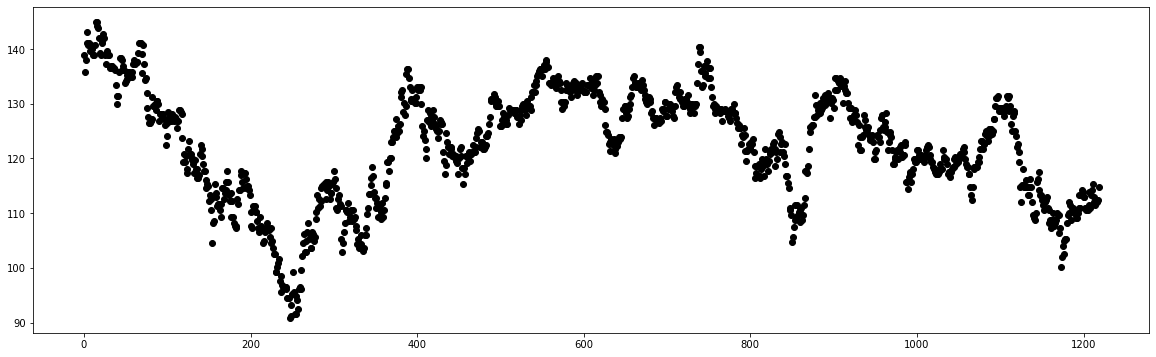

In [101]:

data = series1['Adj Close']
X_train = np.array([[i] for i in range(np.shape(data.values)[0])]) # Single parameter value
y_train = data.values

plt.scatter(X_train, y_train,  color='black')

In [102]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [103]:
# Model parameter
regr.score(X_train, y_train), regr.coef_, regr.intercept_

(0.0033791468608812547, array([-0.00166656]), 123.35846728991535)

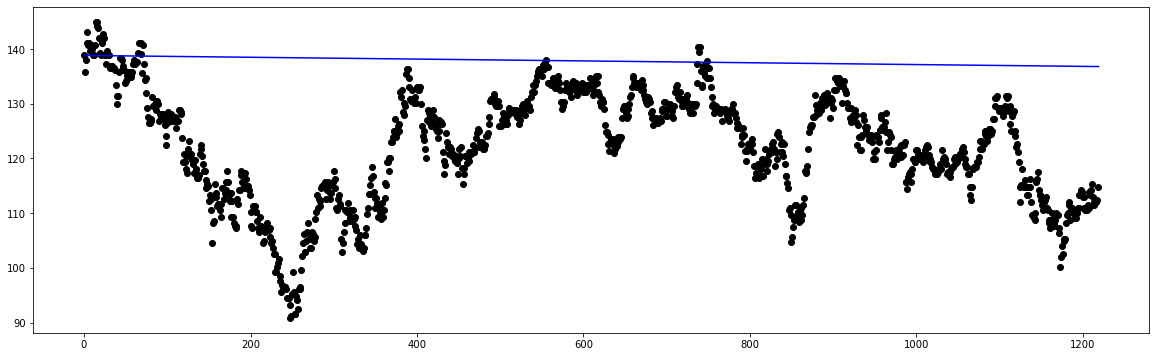

In [104]:
# Make sure the scatter and the line are scaled correctly.
# 1. Add +b offset to y = a * x + b
# 2. The linspace for plotting line should match the range of the scatter. Use len() on the dataframe.

# Plot simple line
x = np.linspace(0, len(data)) # See https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html
y = (regr.coef_[0] * x) + data[0]

fig = plt.figure()
ax = plt.axes()
ax.scatter(X_train, y_train,  color='black')
ax.plot(x, y, color='blue')
plt.show()

# Trendline for 200, 400 days

In [105]:
df = series1[['Ticker', 'Date', 'Adj Close']]
df.tail()

,Ticker,Date,Adj Close
Date,,,
2019-12-24,SCB,2019-12-24,111.477440
2019-12-25,SCB,2019-12-25,112.418182
2019-12-26,SCB,2019-12-26,111.947807
2019-12-27,SCB,2019-12-27,112.418182
2019-12-30,SCB,2019-12-30,114.770027


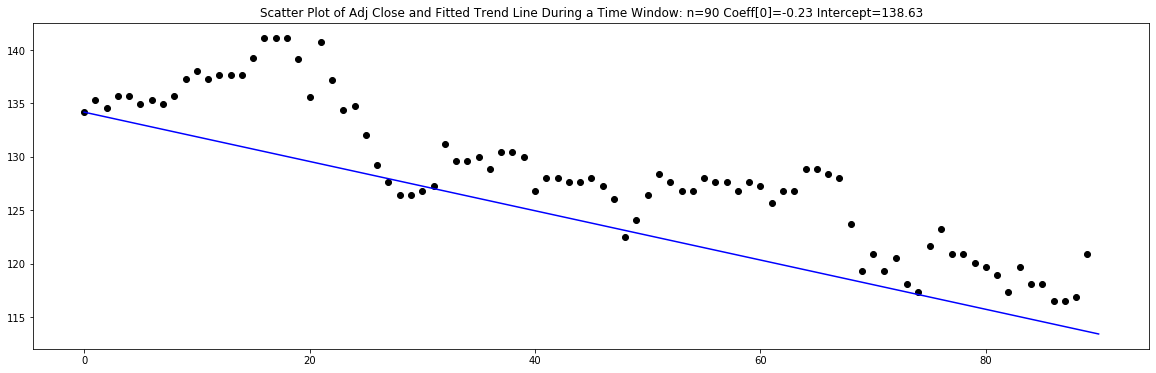

Date
2015-03-17    134.184677
2015-03-18    135.348114
2015-03-19    134.572479
2015-03-20    135.735931
2015-03-23    135.735931
                 ...    
2015-07-24    118.101730
2015-07-27    116.511139
2015-07-28    116.511139
2015-07-29    116.908783
2015-07-31    120.885277
Name: Adj Close, Length: 90, dtype: float64

In [135]:
# Get 200 day
calc_period = df[-200:]


def fit_trend(data, plot=True):
    """Data is np.array."""
    X_train = np.array([[i] for i in range(np.shape(data)[0])]) # Single parameter value
    y_train = data
    ndays = len(y_train)

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Model parameter
    fit_score, coef, intercept = regr.score(X_train, y_train), regr.coef_, regr.intercept_
    
    # Show plot
    if plot:    
        # Plot simple line
        x = np.linspace(0, len(data)) # See https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html
        y = (regr.coef_[0] * x) + data[0]
        fig = plt.figure()
        ax = plt.axes()
        ax.scatter(X_train, y_train,  color='black')
        ax.plot(x, y, color='blue')
        plt.title("Scatter Plot of Adj Close and Fitted Trend Line During a Time Window: n=%d Coeff[0]=%0.2f Intercept=%0.2f" % (ndays, coef[0], intercept))
        plt.show()

    # Return. Slope is coefficient:  y = a*X + c
    return {"fit_score":fit_score, "coef":coef, "intercept":intercept, 'slope': coef}

# Test fit trend function

data = series1[50:140]['Adj Close']
fit_trend(data)    


# calc_period
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


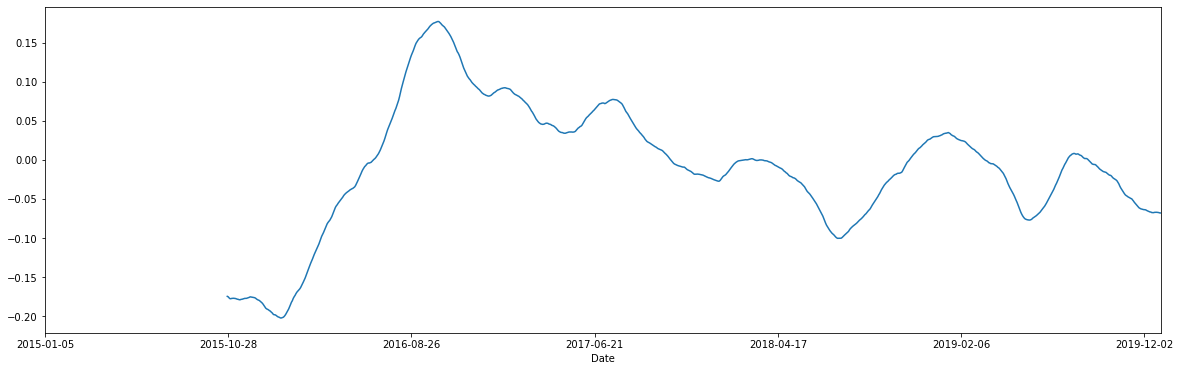

In [109]:
def trendline_slope(x, n):
    # data = x[-n:]
    res = fit_trend(x, plot=False)  
    return res['slope'] # Return slope

trend200_slope = df['Adj Close'].rolling(200).apply(trendline_slope, kwargs={'n':200})
trend200_slope.plot()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


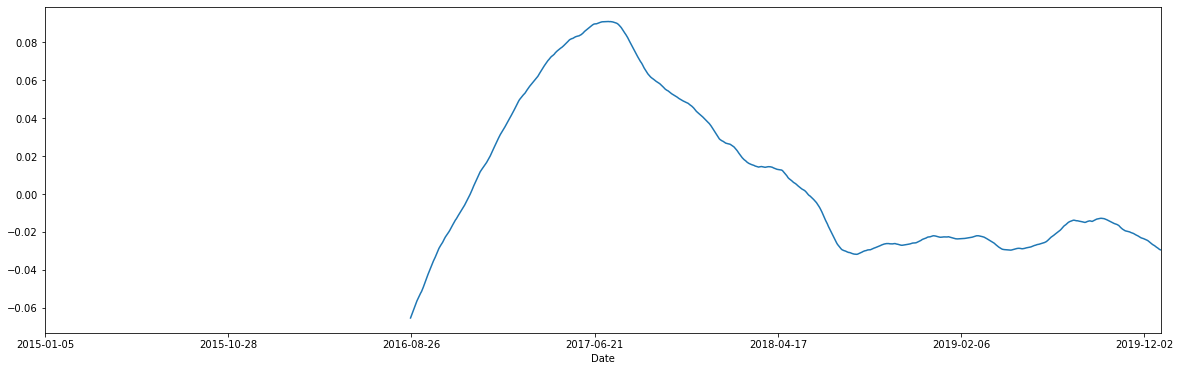

In [110]:
trend400_slope = df['Adj Close'].rolling(400).apply(trendline_slope, kwargs={'n':400})
trend400_slope.plot()

In [111]:
series1['trend200_slope'] = trend200_slope
series1['trend400_slope'] = trend400_slope

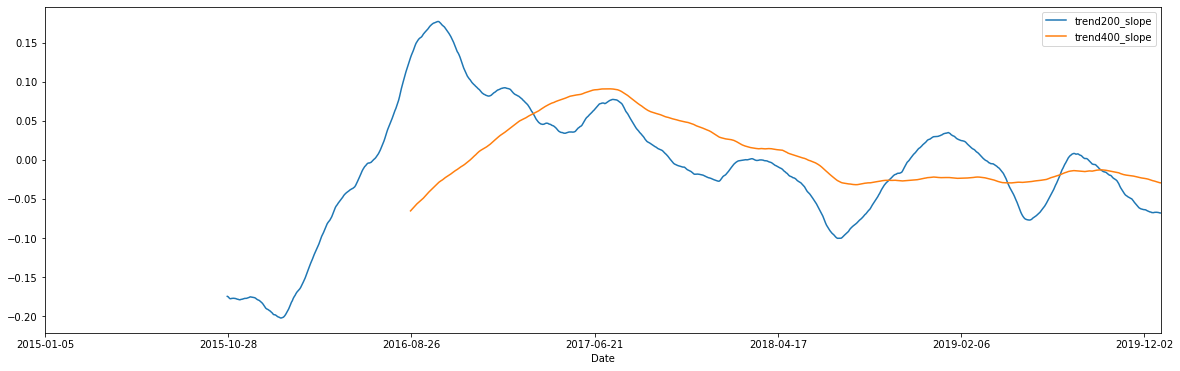

In [114]:
series1[['trend200_slope', 'trend400_slope']].plot()

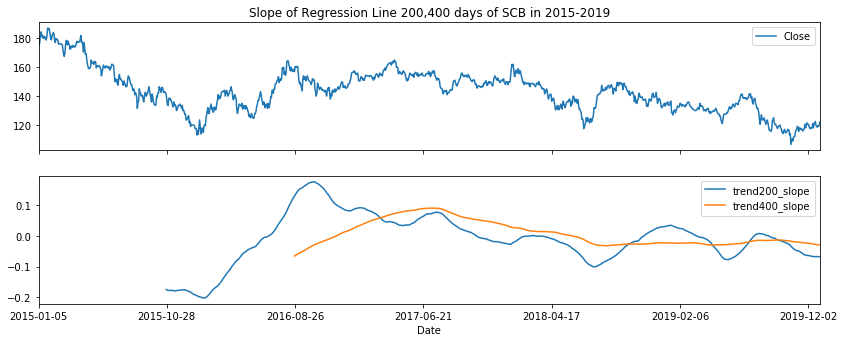

In [117]:
title = "Slope of Regression Line 200,400 days of SCB in 2015-2019"
plt.figure(1)
plt.subplot(3,1,1)
series1[['Close']].plot(ax=plt.gca(), title=title, figsize=(14,8)) #no need to specify for first axis
plt.subplot(3,1,2)
series1[['trend200_slope', 'trend400_slope']].plot(ax=plt.gca(), title="", sharex=True)

In [124]:
series1[['trend200_slope', 'trend400_slope']].tail()

,trend200_slope,trend400_slope
Date,,
2019-12-24,-0.067159,-0.028302
2019-12-25,-0.067305,-0.028635
2019-12-26,-0.067644,-0.029051
2019-12-27,-0.067969,-0.029348
2019-12-30,-0.067932,-0.029472


# Scatter Plot

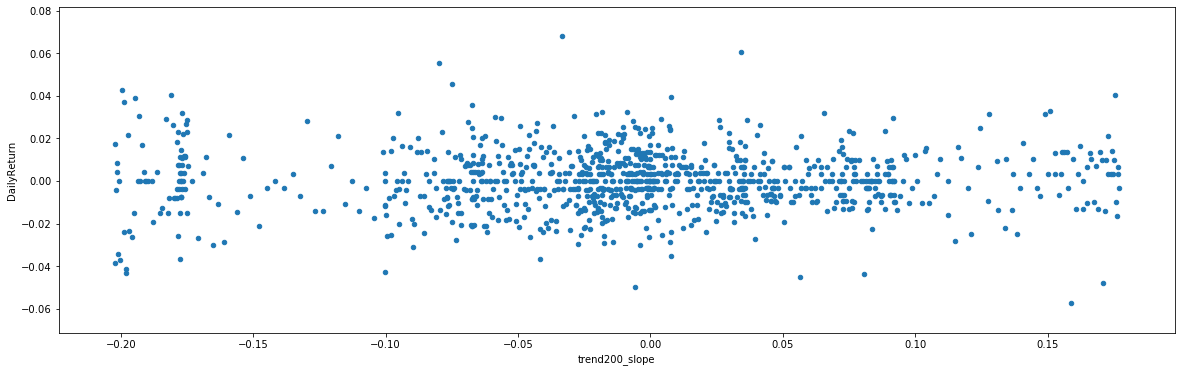

In [122]:
series1[['trend200_slope', 'DailyReturn']].plot.scatter(x='trend200_slope', y='DailyReturn')

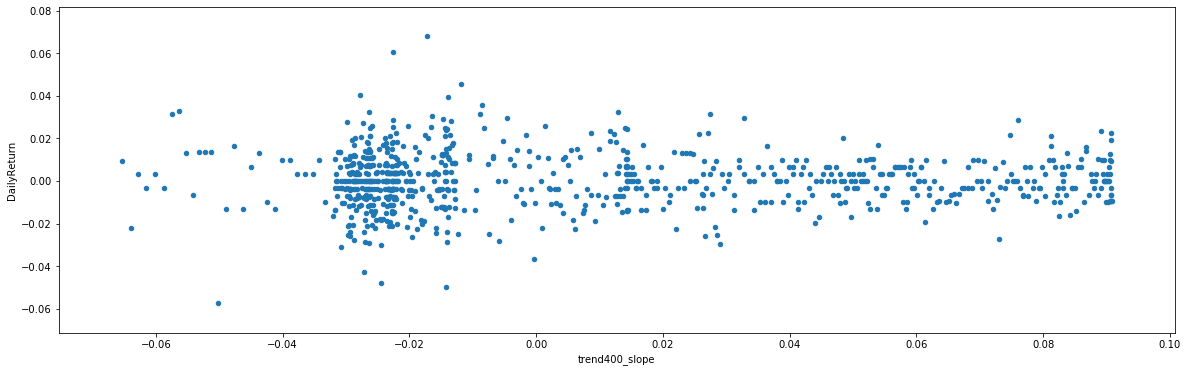

In [123]:
series1[['trend400_slope', 'DailyReturn']].plot.scatter(x='trend400_slope', y='DailyReturn')

In [125]:
# Distribution Plot

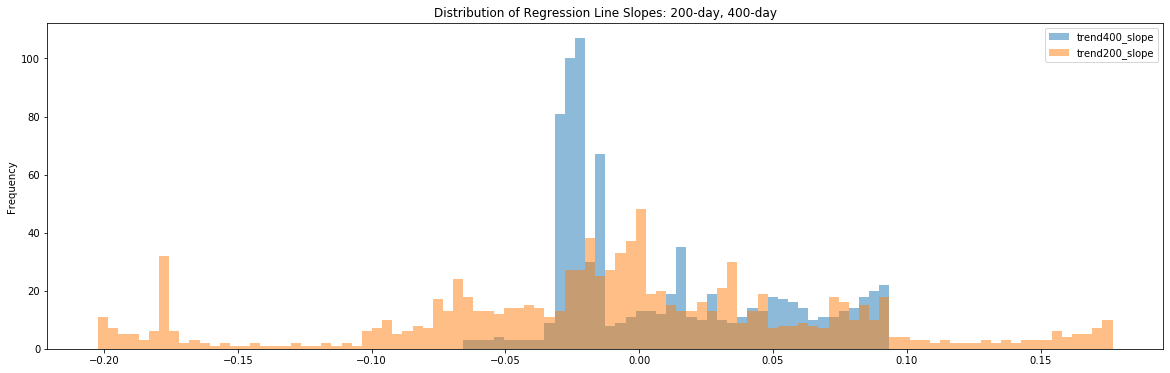

In [132]:
series1[['trend400_slope', 'trend200_slope']].plot.hist(bins=100, alpha=0.5, legend=True, label="Normal", title='Distribution of Regression Line Slopes: 200-day, 400-day')
